# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [122]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')


## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [124]:
# Importing the file porter_data_1.csv
df = pd.read_csv('porter_data_1.csv')
df.head()


market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [126]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df[['created_at', 'actual_delivery_time']].dtypes

created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [132]:
# Convert categorical features to category type

categorical_cols = df.select_dtypes(include='object').columns
df[categorical_cols] = df[categorical_cols].astype('category')
df[categorical_cols].dtypes


Series([], dtype: object)

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [136]:
# Calculate time taken in minutes
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# Calculate time difference in minutes
df['time_taken_mins'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60



##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [138]:
# Extract the hour and day of week from the 'created_at' timestamp
df['order_hour'] = df['created_at'].dt.hour
df['order_day'] = df['created_at'].dt.day_name()

# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['order_day'].isin(['Saturday', 'Sunday']).astype('category')


In [140]:
# Drop unnecessary columns
df.drop(['created_at', 'actual_delivery_time'], axis=1, inplace=True)

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [142]:
# Define target variable (y) and features (X)
y = df['time_taken_mins']
X = df.drop(columns=['time_taken_mins'])

# Confirm shapes
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (175777, 15)
y shape: (175777,)


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [144]:
# Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Confirm shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (140621, 15)
X_test shape: (35156, 15)
y_train shape: (140621,)
y_test shape: (35156,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [148]:
# Define numerical and categorical columns for easy EDA and data manipulation
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include='category').columns.tolist()

df[df.select_dtypes(include='object').columns] = df.select_dtypes(include='object').astype('category')
categorical_cols = df.select_dtypes(include='category').columns.tolist()
# Display the lists
print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)


Categorical columns: ['order_day', 'isWeekend']
Numerical columns: ['market_id', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'time_taken_mins']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

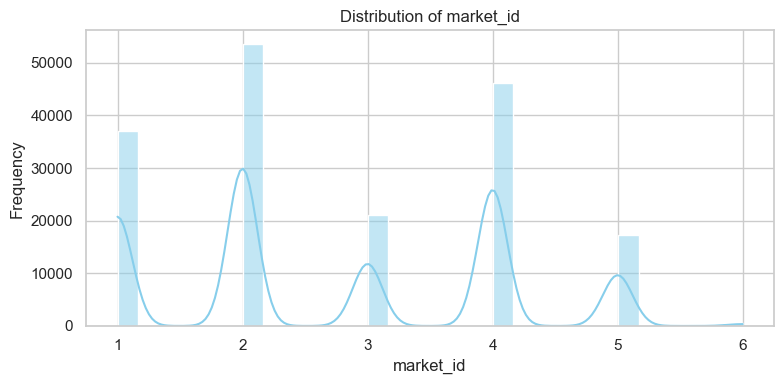

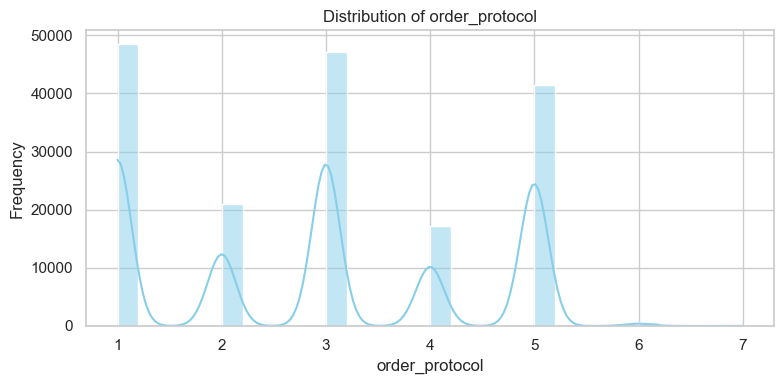

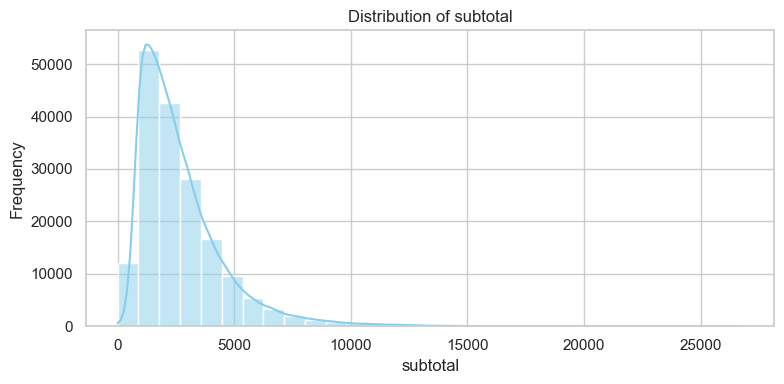

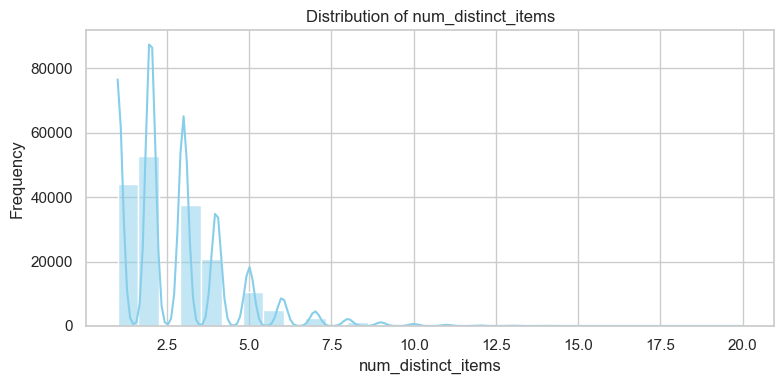

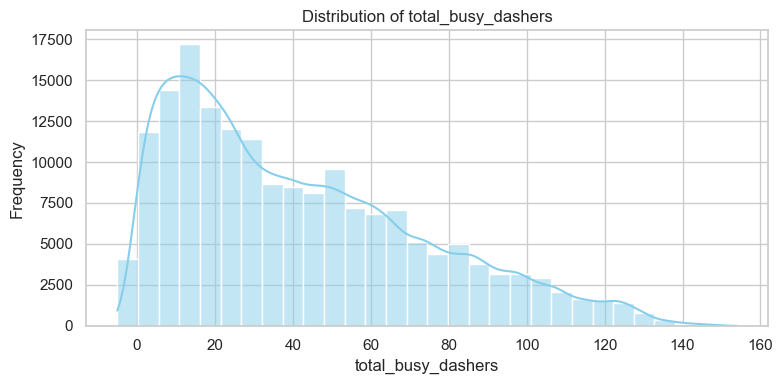

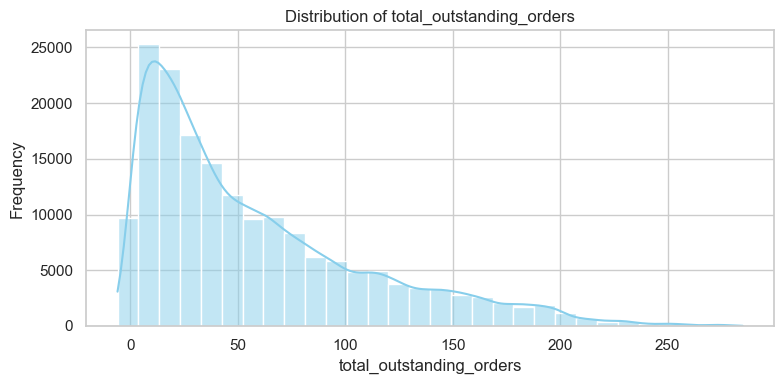

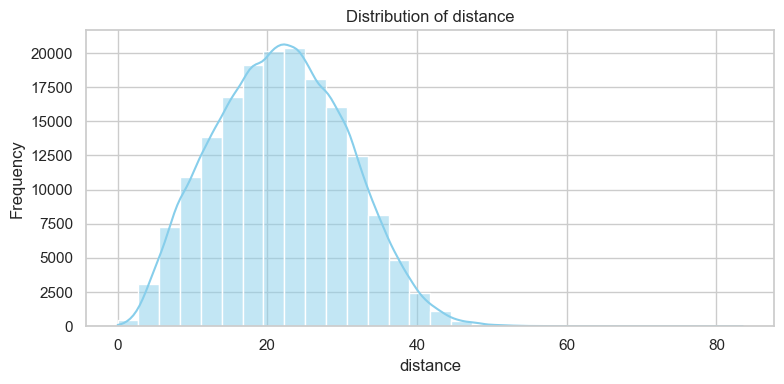

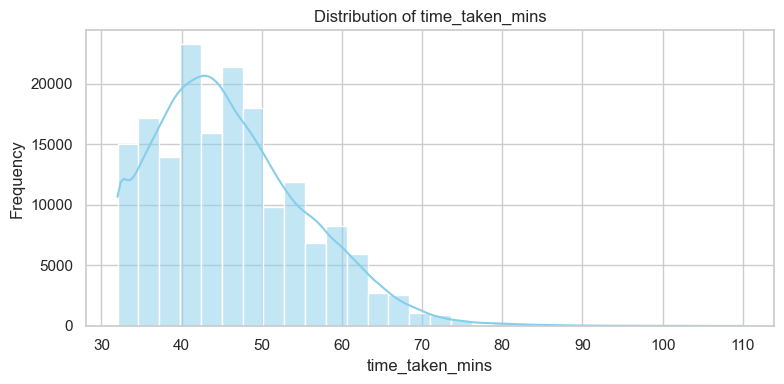

In [150]:
# Plot distributions for all numerical columns
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=col, kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

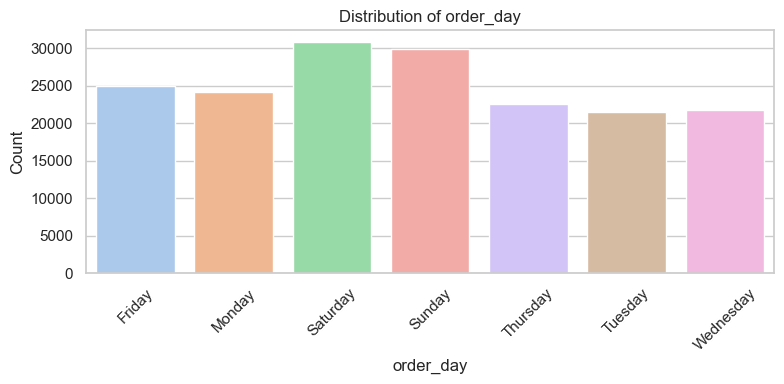

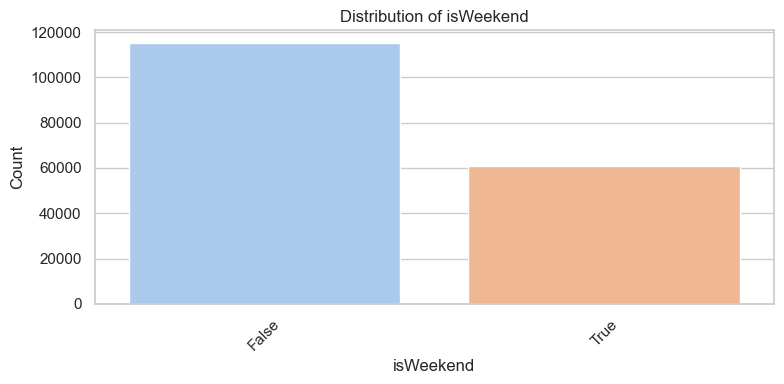

In [152]:
# Distribution of categorical columns
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, palette='pastel')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

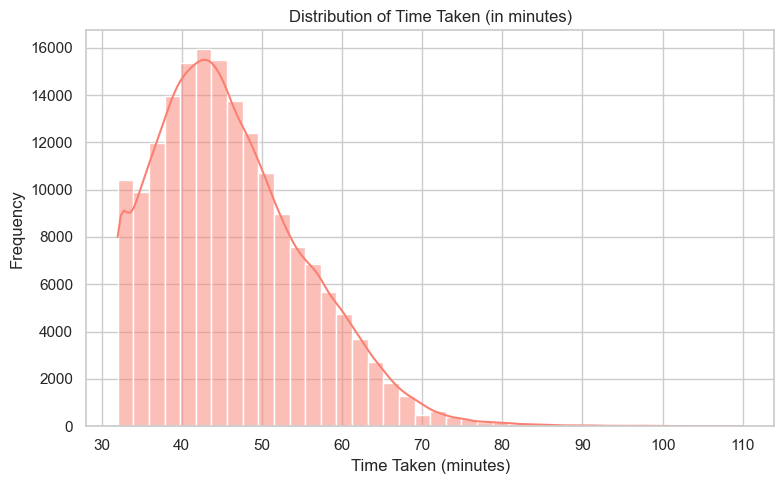

In [154]:
# Distribution of time_taken
plt.figure(figsize=(8, 5))
sns.histplot(df['time_taken_mins'], kde=True, bins=40, color='salmon')
plt.title('Distribution of Time Taken (in minutes)')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

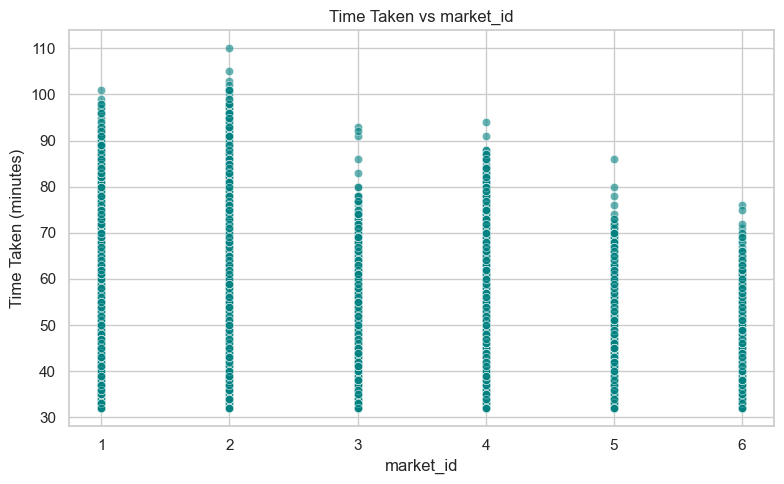

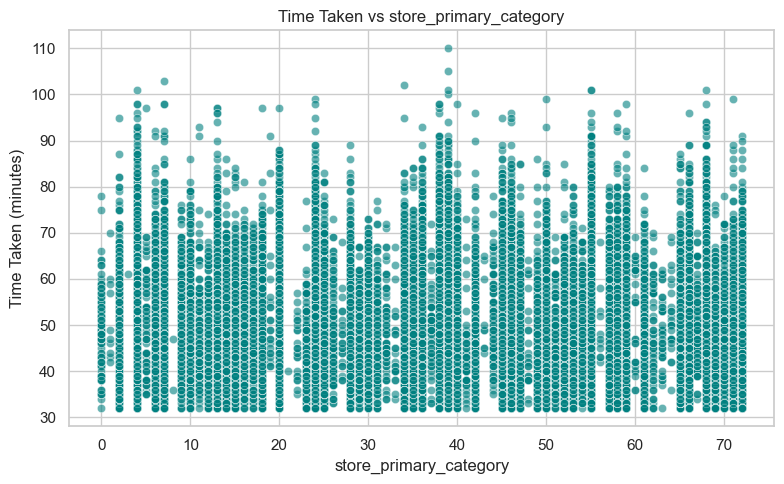

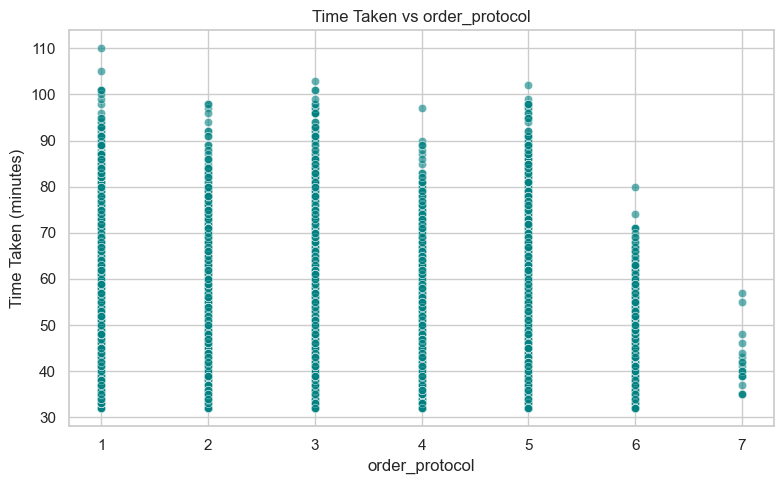

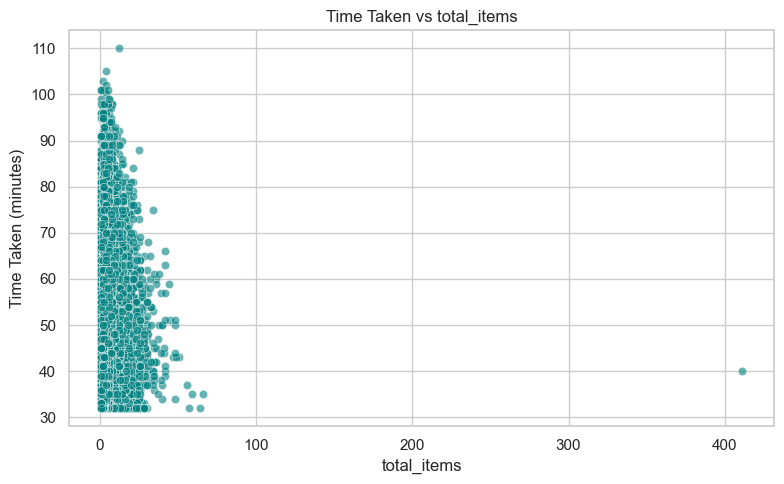

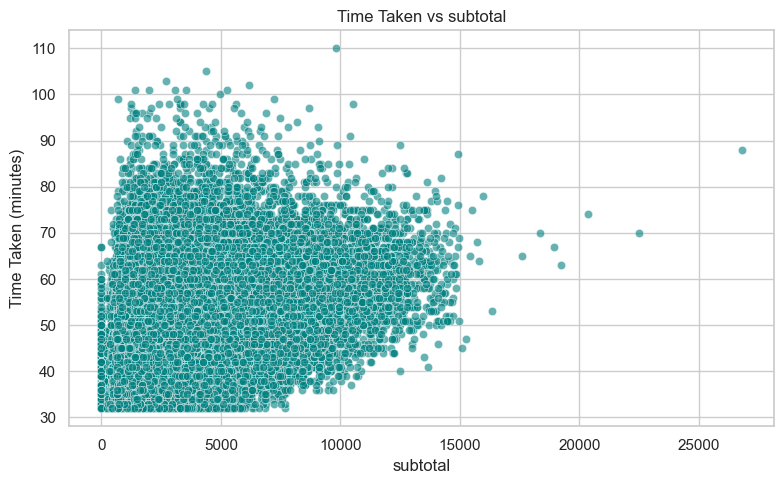

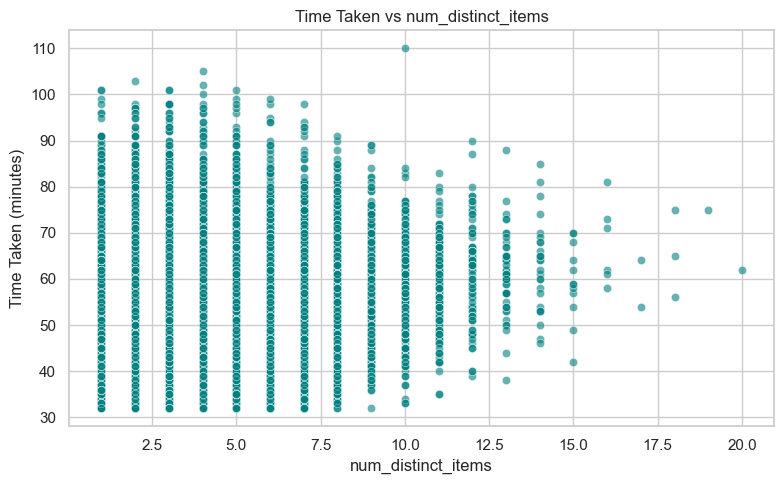

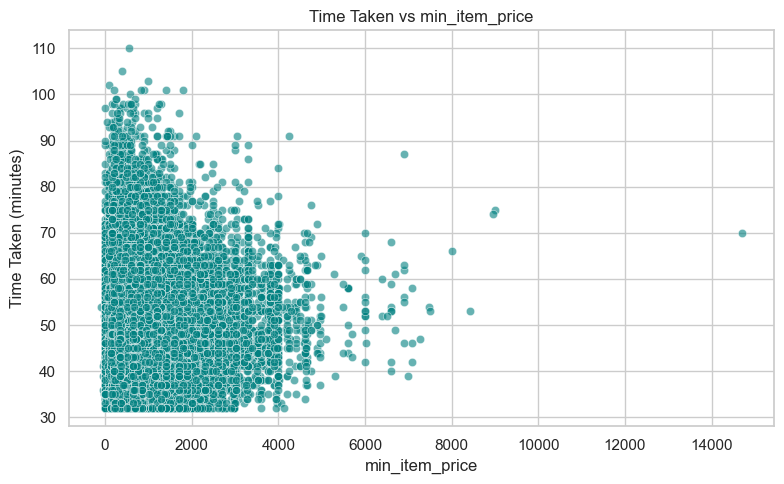

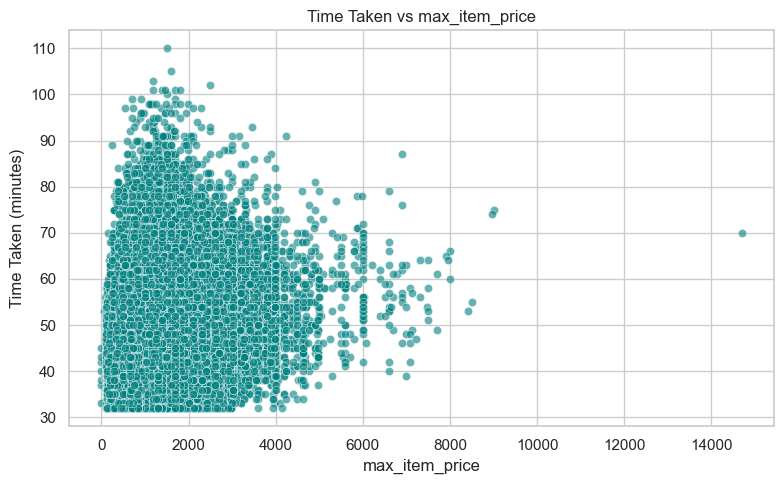

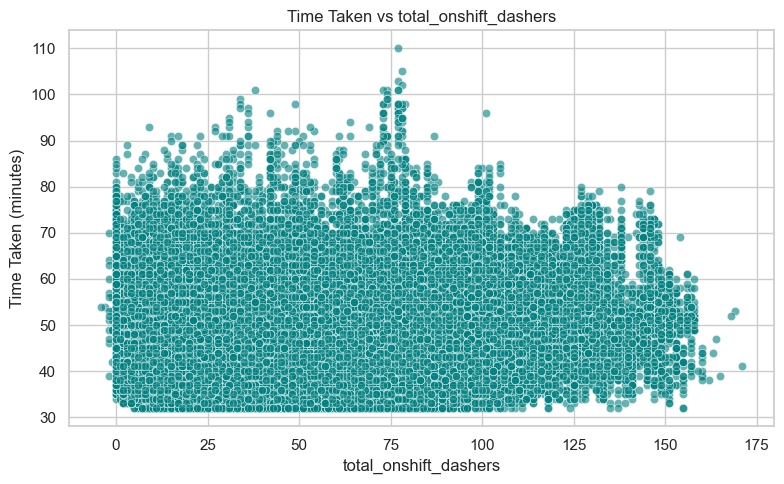

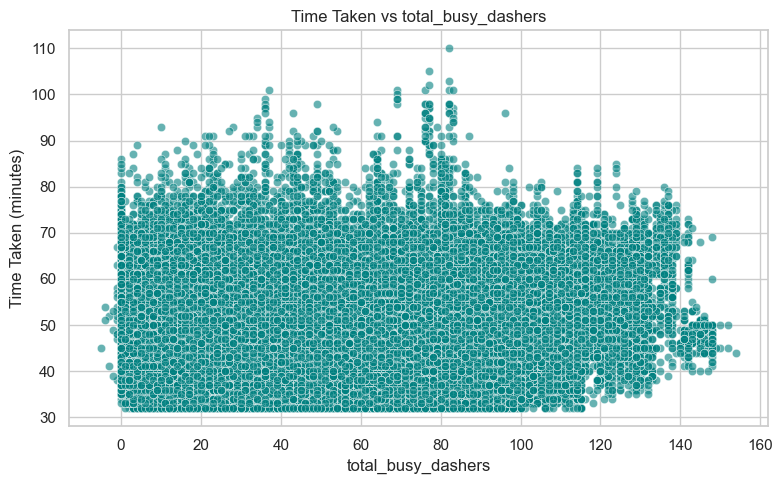

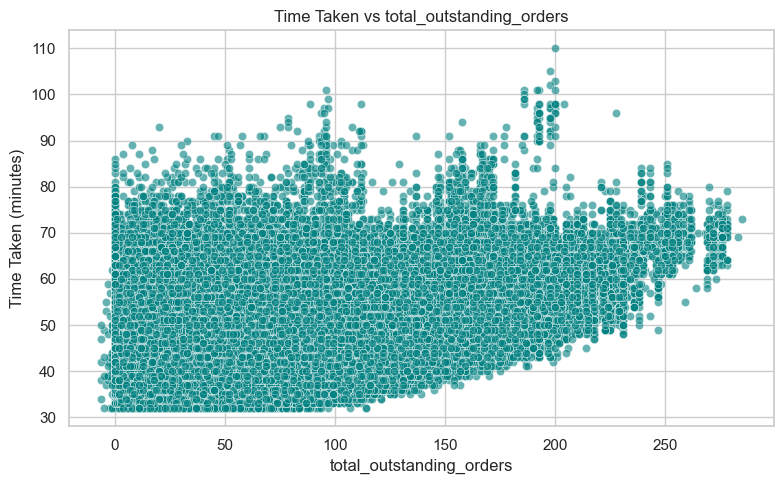

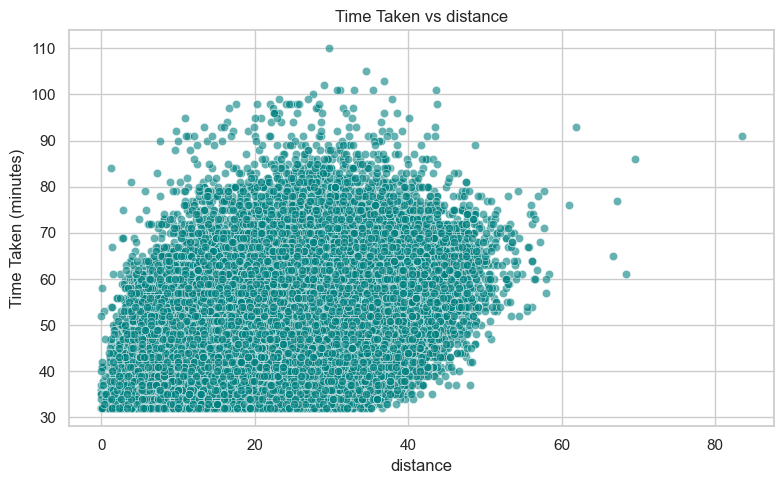

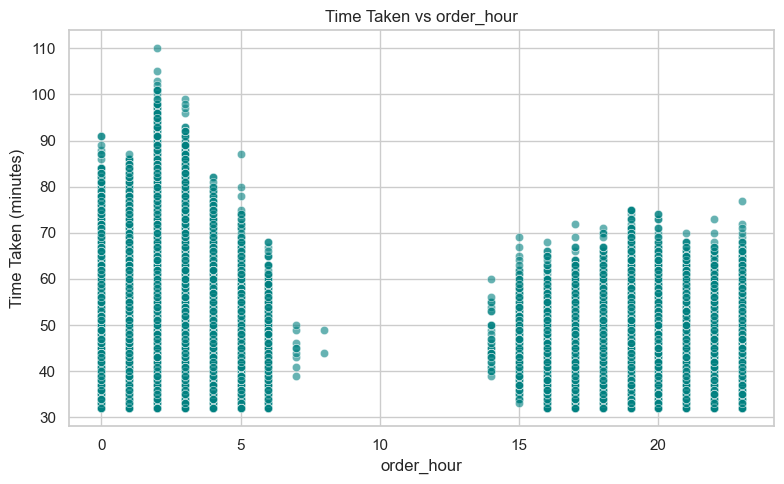

In [156]:
# Scatter plot to visualise the relationship between time_taken and other features
numeric_features = df.select_dtypes(include='number').drop(columns=['time_taken_mins']).columns
for col in numeric_features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=df[col], y=df['time_taken_mins'], alpha=0.6, color='teal')
    plt.title(f'Time Taken vs {col}')
    plt.xlabel(col)
    plt.ylabel('Time Taken (minutes)')
    plt.tight_layout()
    plt.show()




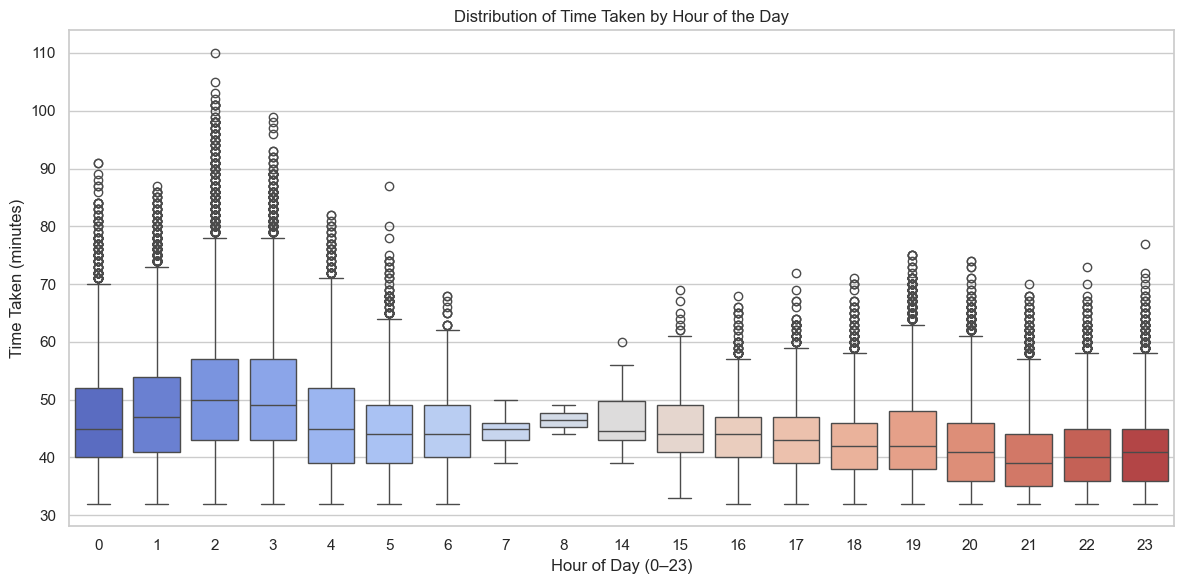

In [158]:
# Show the distribution of time_taken for different hours

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='order_hour', y='time_taken_mins', palette='coolwarm')

plt.title('Distribution of Time Taken by Hour of the Day')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Time Taken (minutes)')
plt.tight_layout()
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

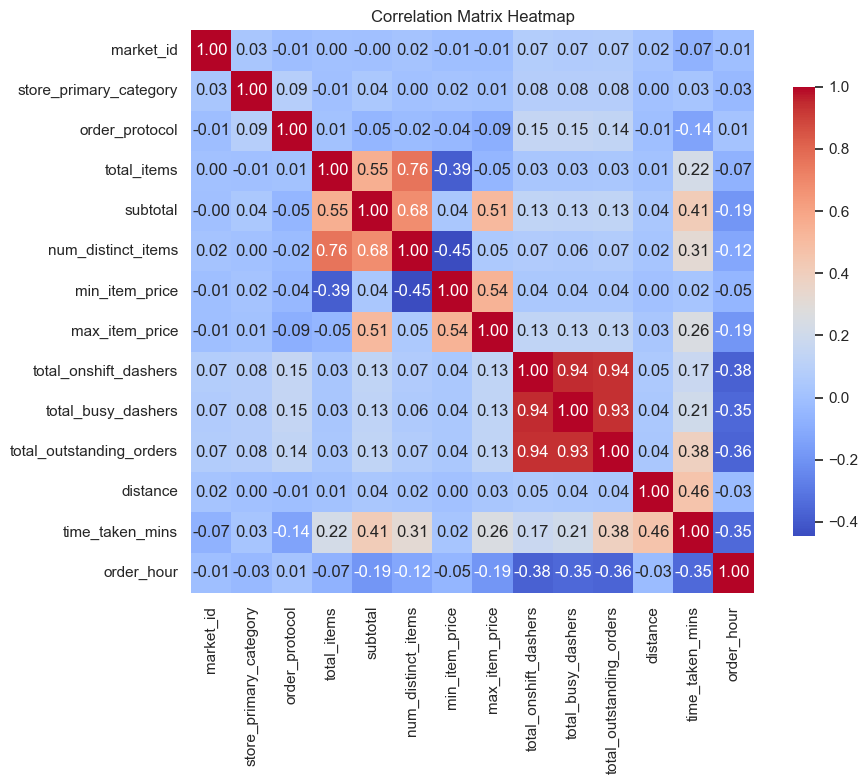

In [160]:
# Plot the heatmap of the correlation matrix
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [162]:
# Drop 3-5 weakly correlated columns from training dataset
corr_with_target = df.corr(numeric_only=True)['time_taken_mins'].drop('time_taken_mins')
weakest_features = corr_with_target.abs().sort_values().head(5).index.tolist()
print("Weakly correlated features to drop:", weakest_features)
X_dropped = X.drop(columns=weakest_features)

Weakly correlated features to drop: ['min_item_price', 'store_primary_category', 'market_id', 'order_protocol', 'total_onshift_dashers']


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

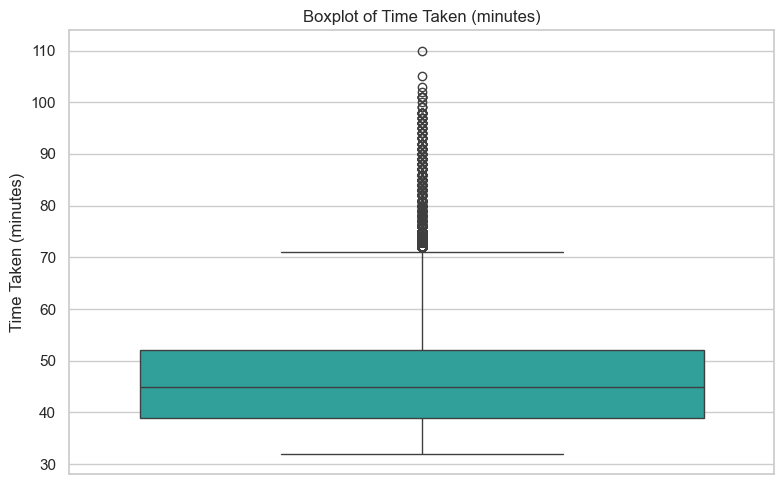

In [164]:
# Boxplot for time_taken
plt.figure(figsize=(8, 5))
sns.boxplot(y=df['time_taken_mins'], color='lightseagreen')
plt.title('Boxplot of Time Taken (minutes)')
plt.ylabel('Time Taken (minutes)')
plt.tight_layout()
plt.show()

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [166]:
# Handle outliers

df_clean = df.copy()
numeric_cols = df_clean.select_dtypes(include=['number']).columns

for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

print(f"Rows remaining after outlier removal: {df_clean.shape[0]}")

Rows remaining after outlier removal: 144987


## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [168]:
# Define numerical and categorical columns for easy EDA and data manipulation
# Numerical columns: 
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical columns:
categorical_cols = df.select_dtypes(include='category').columns.tolist()

# If categorical columns are still object type, convert them 
object_cols = df.select_dtypes(include='object').columns.tolist()
df[object_cols] = df[object_cols].astype('category')
categorical_cols = df.select_dtypes(include='category').columns.tolist()

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['market_id', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'time_taken_mins']
Categorical columns: ['order_day', 'isWeekend']


#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

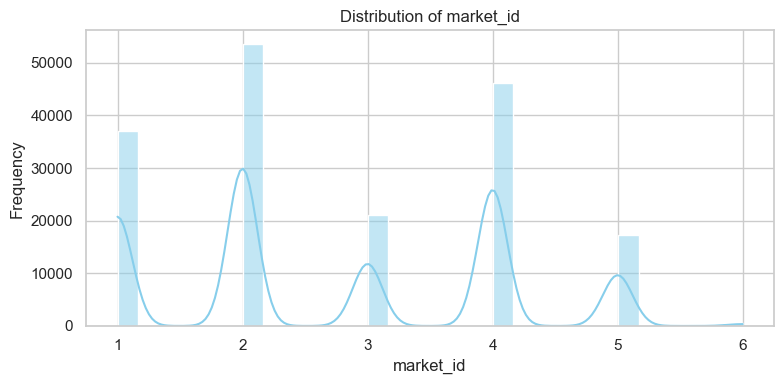

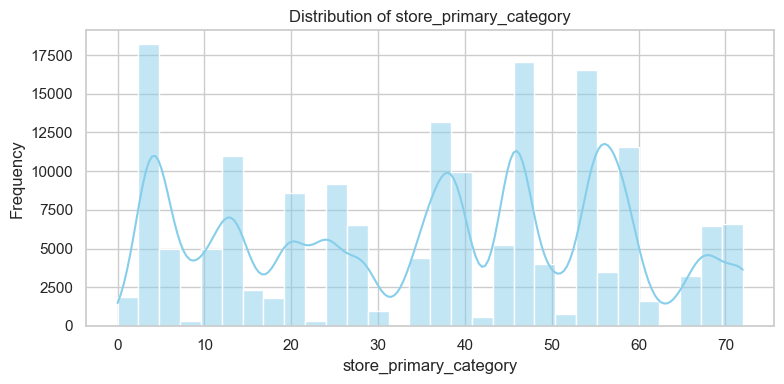

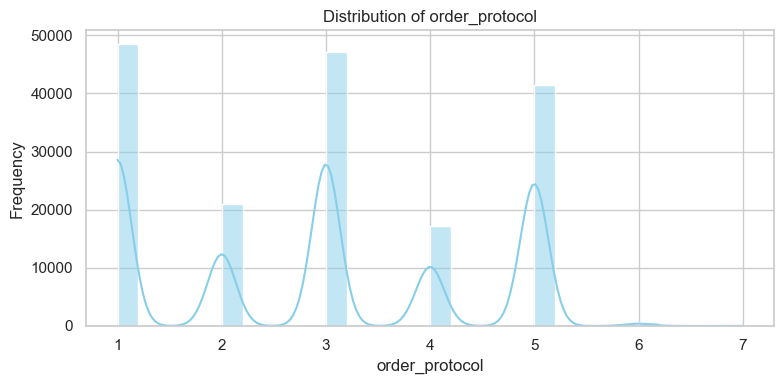

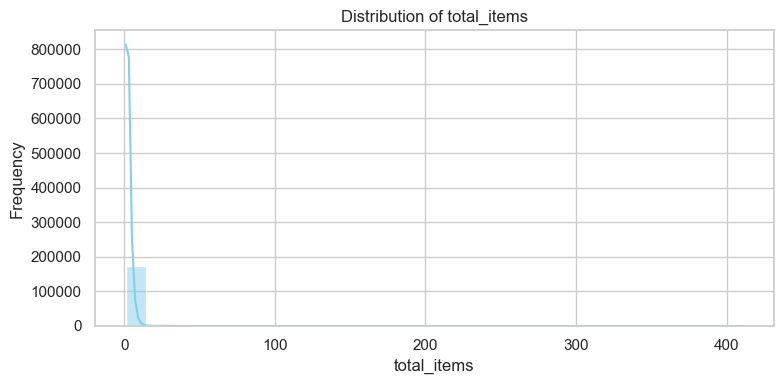

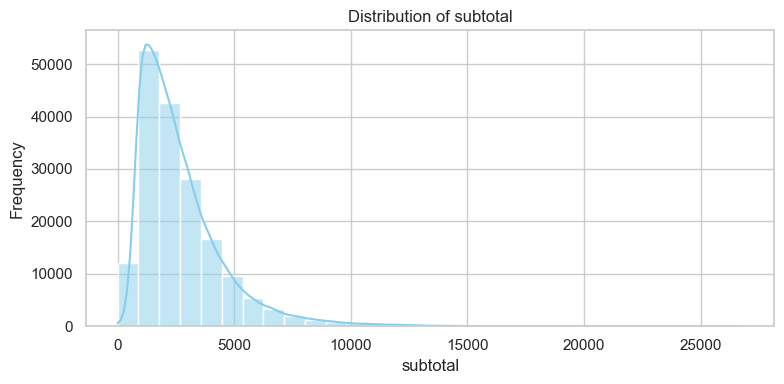

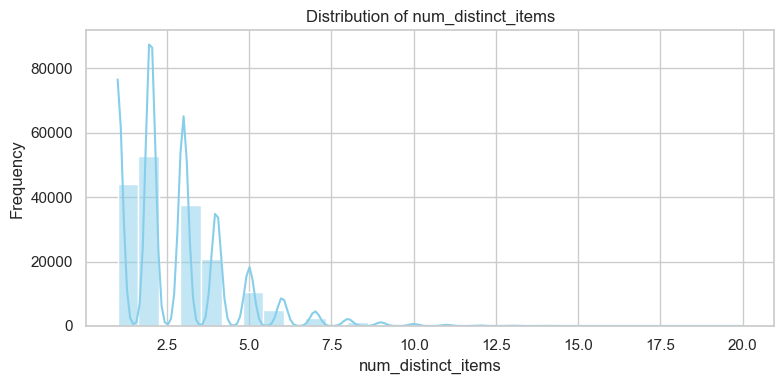

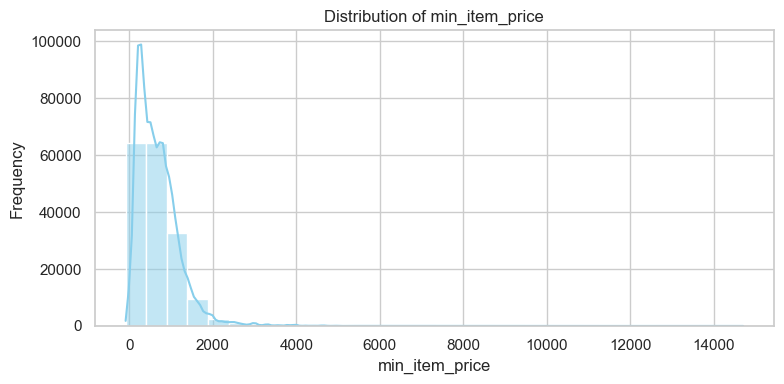

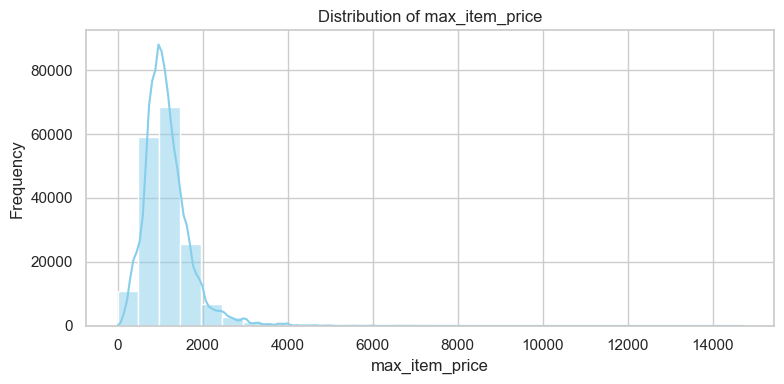

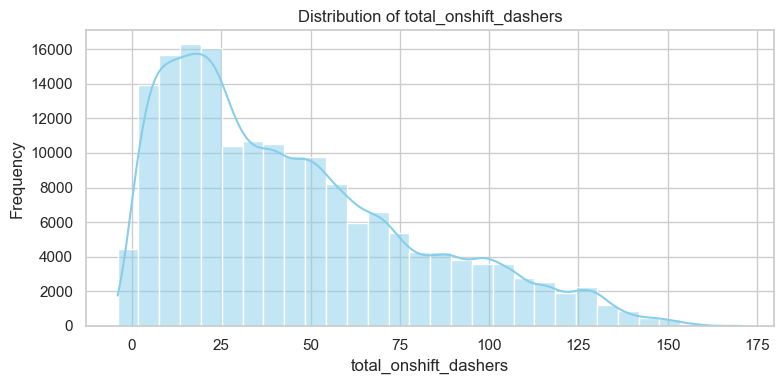

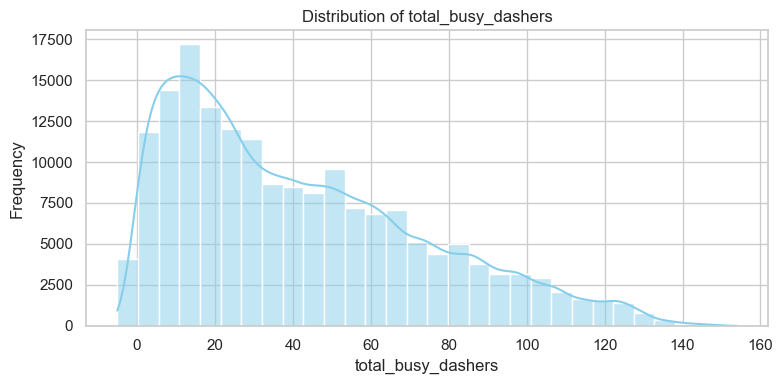

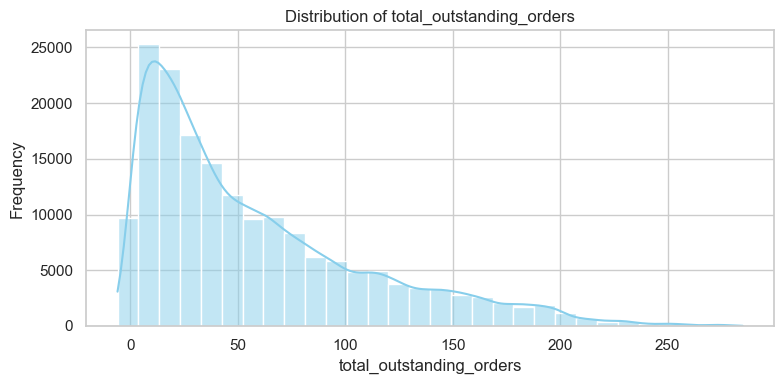

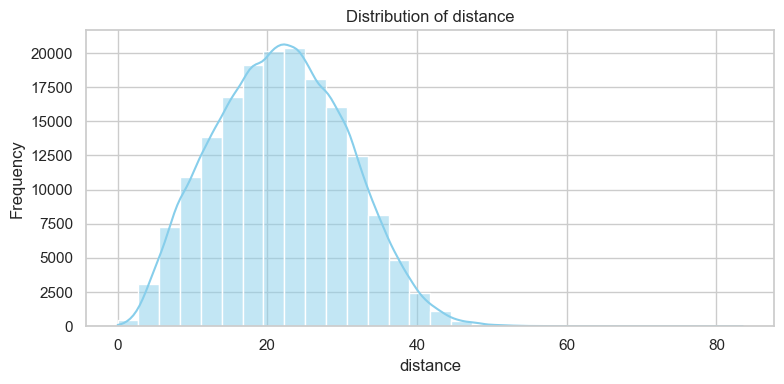

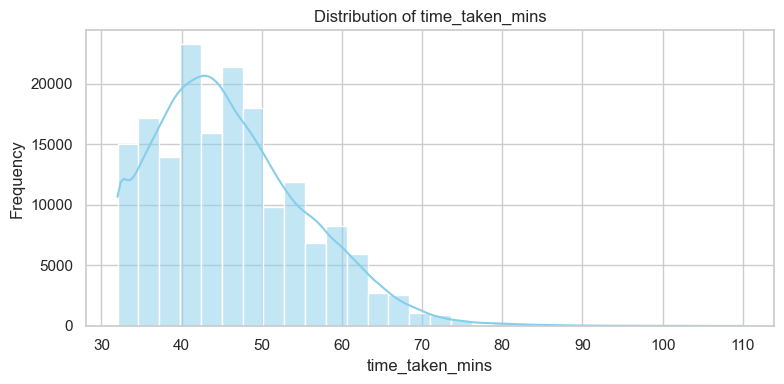

In [170]:
# Plot distributions for all numerical columns
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()


##### **4.1.2**
Check the distribution of categorical features

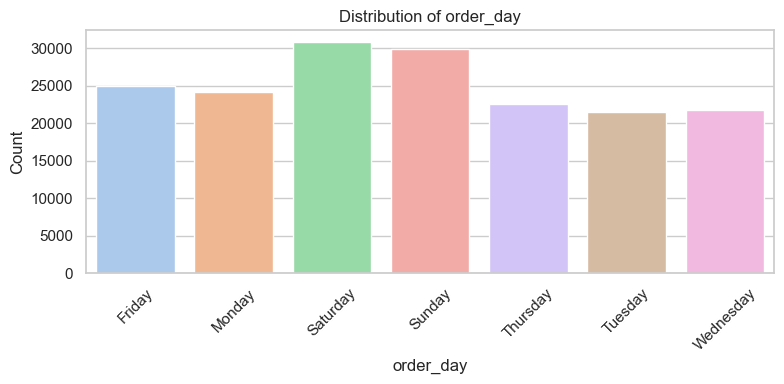

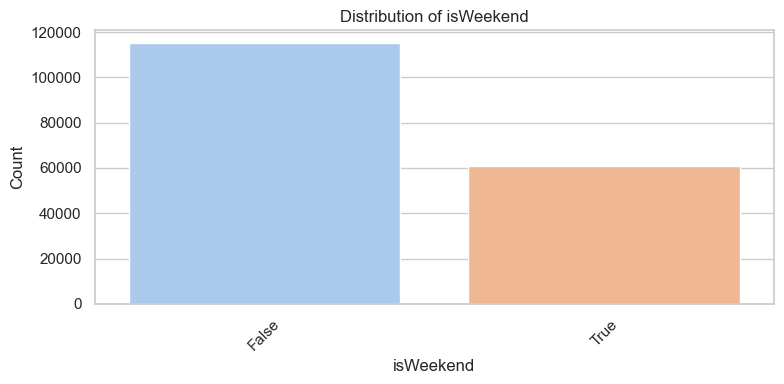

In [172]:
# Distribution of categorical columns

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, palette='pastel')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

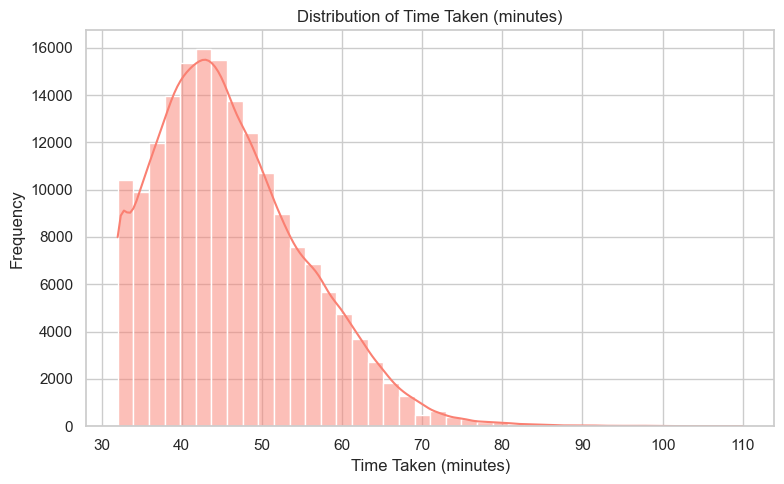

In [174]:
# Distribution of time_taken
plt.figure(figsize=(8, 5))
sns.histplot(df['time_taken_mins'], bins=40, kde=True, color='salmon')
plt.title('Distribution of Time Taken (minutes)')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

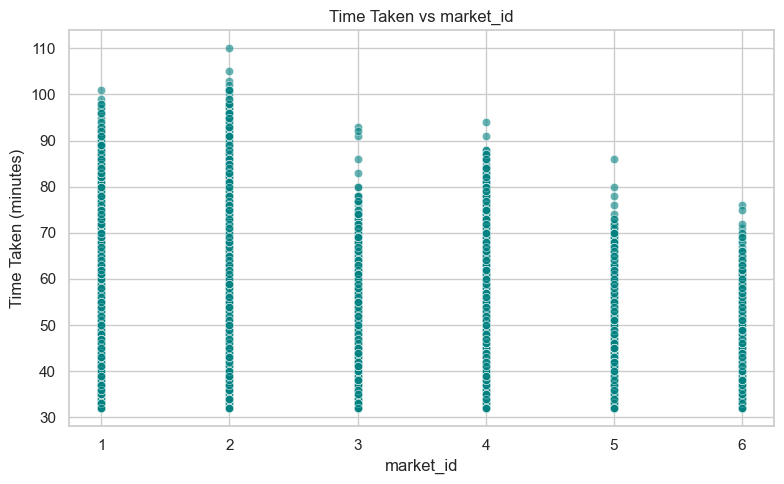

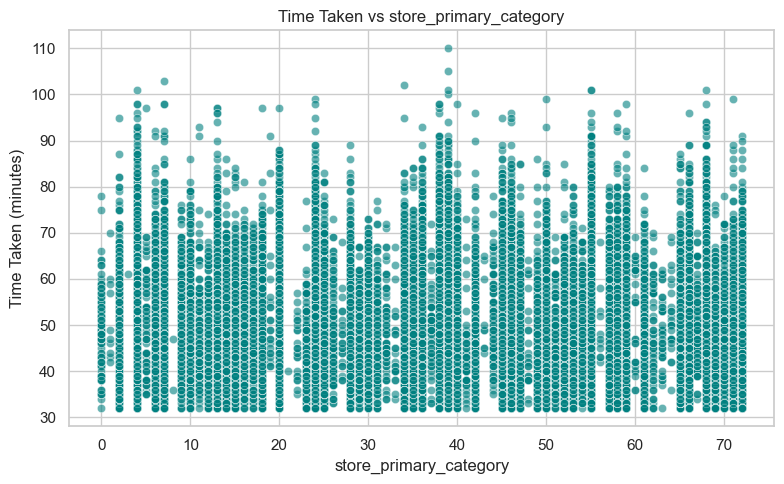

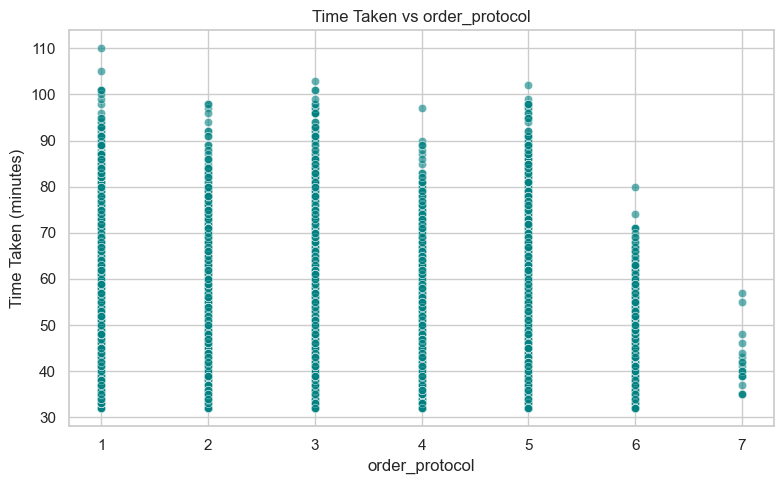

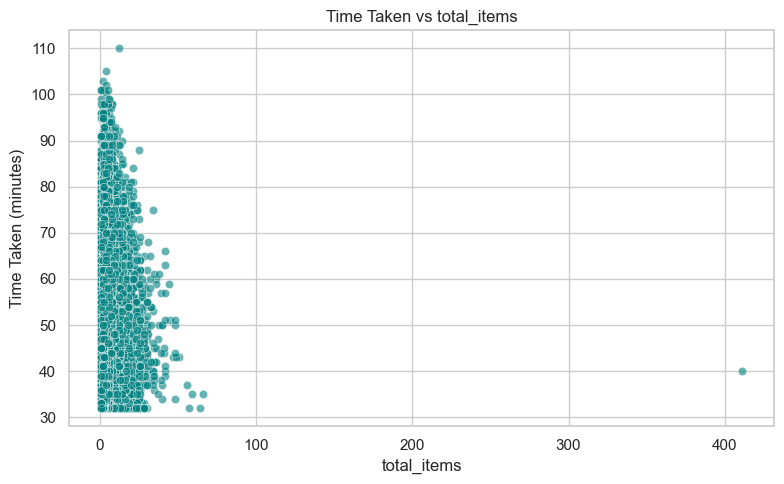

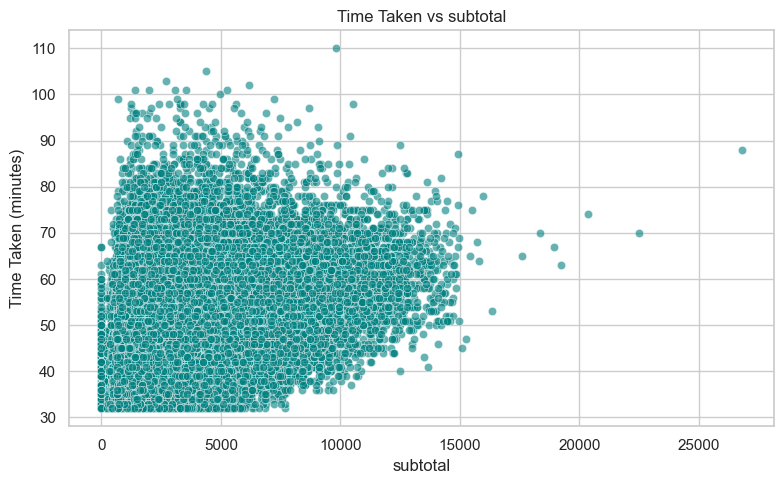

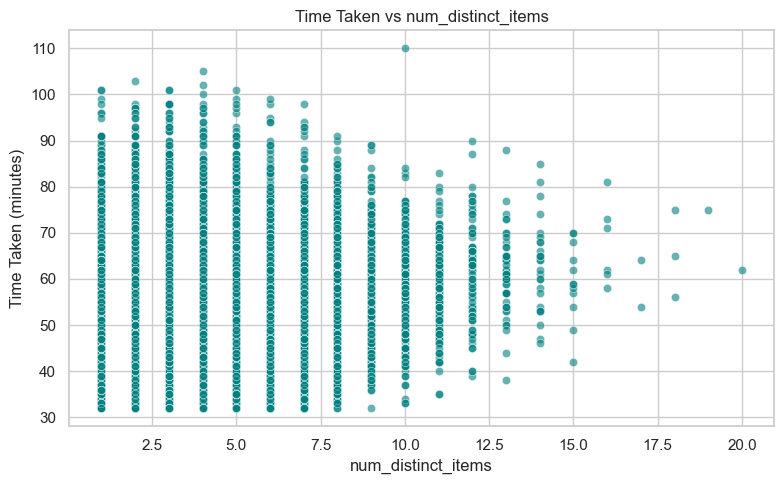

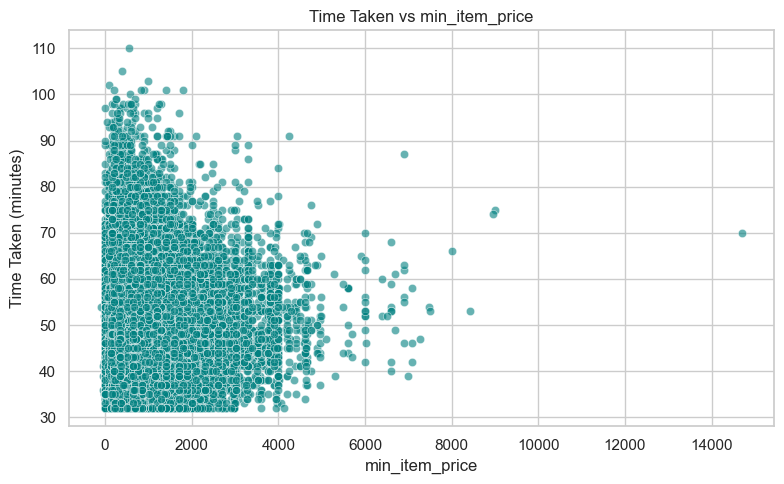

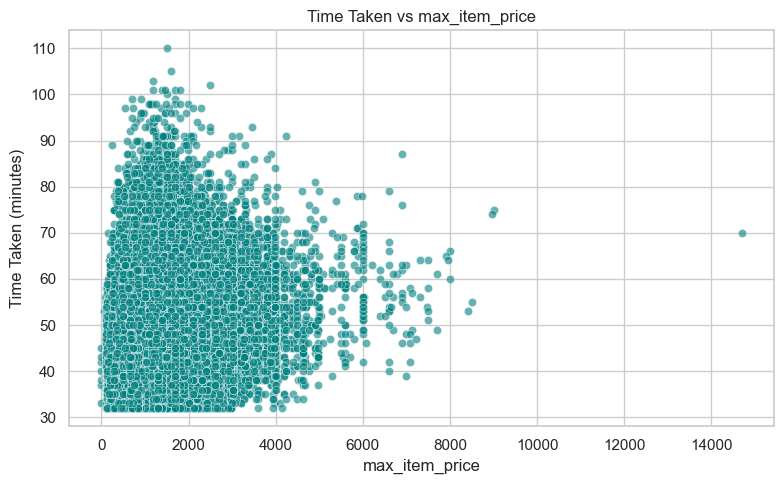

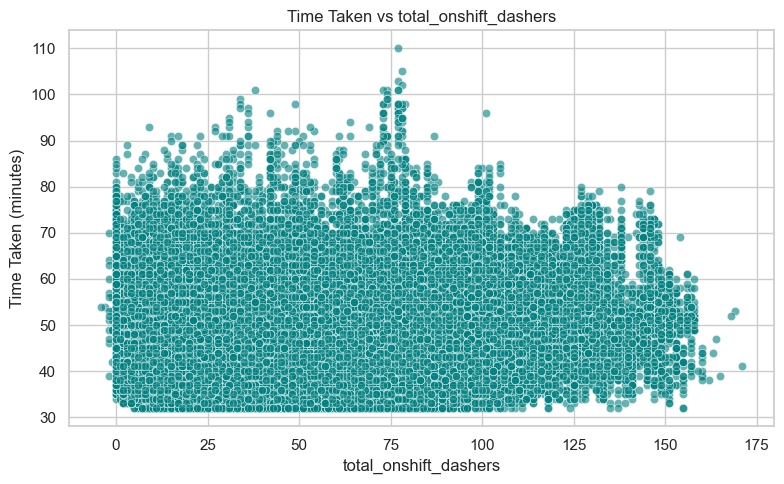

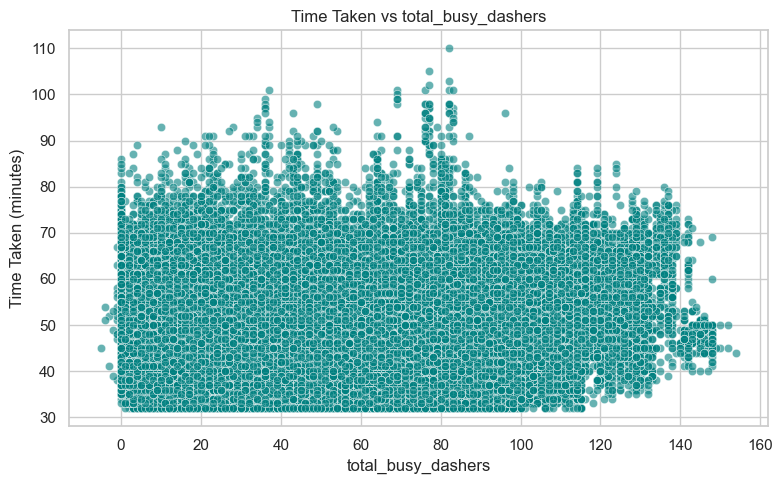

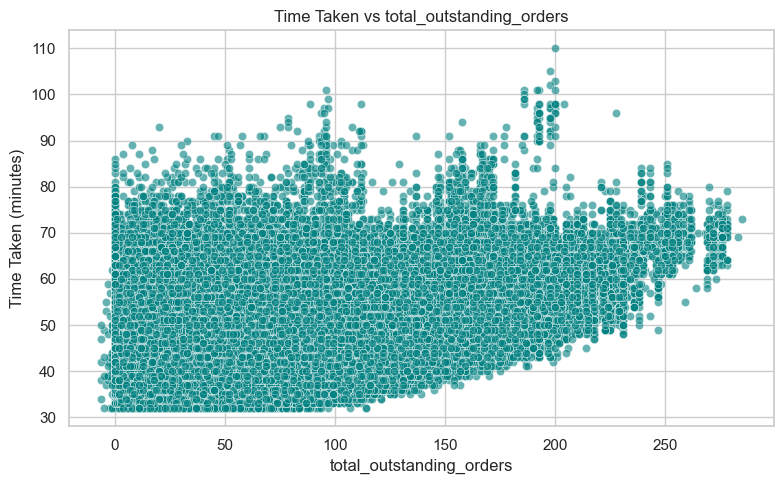

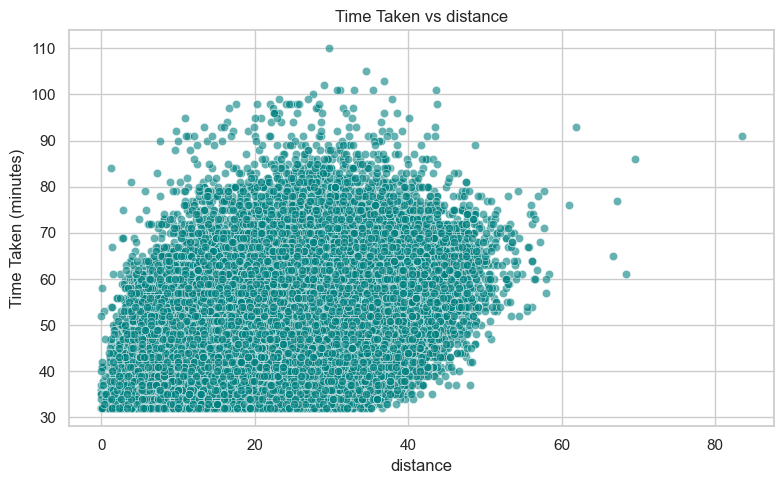

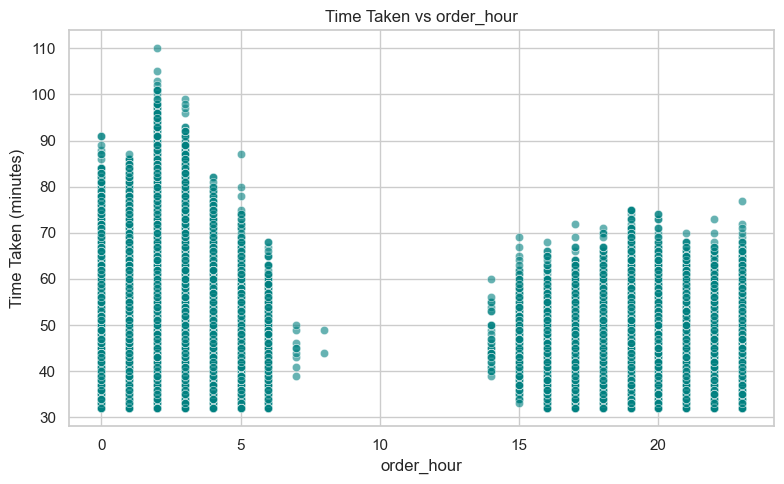

In [176]:
# Scatter plot to visualise the relationship between time_taken and other features
numeric_features = df.select_dtypes(include='number').drop(columns=['time_taken_mins']).columns

for col in numeric_features:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df, x=col, y='time_taken_mins', alpha=0.6, color='teal')
    plt.title(f'Time Taken vs {col}')
    plt.xlabel(col)
    plt.ylabel('Time Taken (minutes)')
    plt.tight_layout()
    plt.show()


#### **4.3** Drop the columns with weak correlations with the target variable

In [178]:
# Drop the weakly correlated columns from training dataset
corr_with_target = df.corr(numeric_only=True)['time_taken_mins'].drop('time_taken_mins')
weak_features = corr_with_target[abs(corr_with_target) < 0.1].index.tolist()

print("Weakly correlated features to drop:", weak_features)
X_train_dropped = X_train.drop(columns=weak_features)
X_test_dropped = X_test.drop(columns=weak_features)  # also drop from test to keep consistent

Weakly correlated features to drop: ['market_id', 'store_primary_category', 'min_item_price']


## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [186]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # optional, if scaling needed

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings('ignore')


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [198]:
# Apply scaling to the numerical columns
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [210]:
# Create/Initialise the model
categorical_cols = df.select_dtypes(include='category').columns.tolist()
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
X = df_encoded.drop(columns=['time_taken_mins'])
y = df_encoded['time_taken_mins']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [212]:
# Train the model using the training data
model.fit(X_train, y_train)

LinearRegression()

In [214]:
# Make predictions
y_pred = model.predict(X_test)

# Optional: view first 10 predictions
print(y_pred[:10])


[49.96835537 67.32338884 41.68707168 41.48851488 40.68231869 27.6841032
 35.46299656 42.76436747 31.07661847 46.79120774]


In [216]:
# Find results for evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on test data
y_pred = model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


R² Score: 0.8892
Mean Absolute Error (MAE): 2.29
Mean Squared Error (MSE): 9.70
Root Mean Squared Error (RMSE): 3.11


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [220]:
# Loop through the number of features and test the model

# Initialize model
base_model = LinearRegression()

# Store results
results = []

# Loop through 1 to all features
for n in range(1, X_train.shape[1] + 1):
    rfe = RFE(estimator=base_model, n_features_to_select=n)
    rfe.fit(X_train, y_train)

    # Select features
    selected_features = X_train.columns[rfe.support_]

    # Train model on selected features
    base_model.fit(X_train[selected_features], y_train)
    y_pred = base_model.predict(X_test[selected_features])

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append((n, rmse, r2))

    print(f"Features: {n}, RMSE: {rmse:.2f}, R²: {r2:.4f}")


Features: 1, RMSE: 9.30, R²: 0.0111
Features: 2, RMSE: 9.27, R²: 0.0187
Features: 3, RMSE: 9.24, R²: 0.0239
Features: 4, RMSE: 9.23, R²: 0.0271
Features: 5, RMSE: 8.78, R²: 0.1202
Features: 6, RMSE: 8.70, R²: 0.1359
Features: 7, RMSE: 8.69, R²: 0.1365
Features: 8, RMSE: 8.67, R²: 0.1419
Features: 9, RMSE: 7.57, R²: 0.3455
Features: 10, RMSE: 7.44, R²: 0.3676
Features: 11, RMSE: 4.51, R²: 0.7680
Features: 12, RMSE: 3.89, R²: 0.8268
Features: 13, RMSE: 3.89, R²: 0.8268
Features: 14, RMSE: 3.89, R²: 0.8268
Features: 15, RMSE: 3.65, R²: 0.8477
Features: 16, RMSE: 3.65, R²: 0.8477
Features: 17, RMSE: 3.64, R²: 0.8482
Features: 18, RMSE: 3.13, R²: 0.8883
Features: 19, RMSE: 3.12, R²: 0.8891
Features: 20, RMSE: 3.11, R²: 0.8892


In [222]:
# Build the final model with selected number of features
final_model = LinearRegression()
rfe_final = RFE(estimator=final_model, n_features_to_select=8)
rfe_final.fit(X_train, y_train)

# Get selected features
final_features = X_train.columns[rfe_final.support_].tolist()
print("Selected final features:", final_features)

final_model.fit(X_train[final_features], y_train)

# Predict on test set
y_pred = final_model.predict(X_test[final_features])

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nFinal Model Evaluation:")
print(f"Selected Features: {final_features}")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


Selected final features: ['market_id', 'order_protocol', 'num_distinct_items', 'order_day_Monday', 'order_day_Sunday', 'order_day_Thursday', 'order_day_Tuesday', 'order_day_Wednesday']

Final Model Evaluation:
Selected Features: ['market_id', 'order_protocol', 'num_distinct_items', 'order_day_Monday', 'order_day_Sunday', 'order_day_Thursday', 'order_day_Tuesday', 'order_day_Wednesday']
R² Score: 0.1419
MAE: 6.85
RMSE: 8.67


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

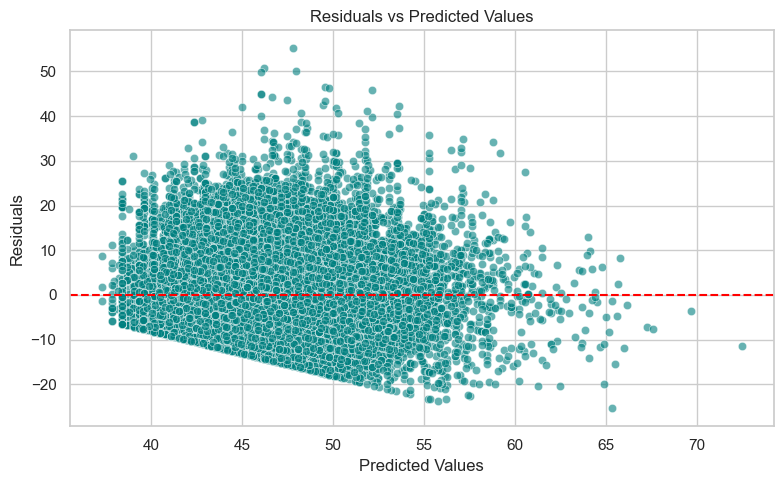

<Figure size 600x600 with 0 Axes>

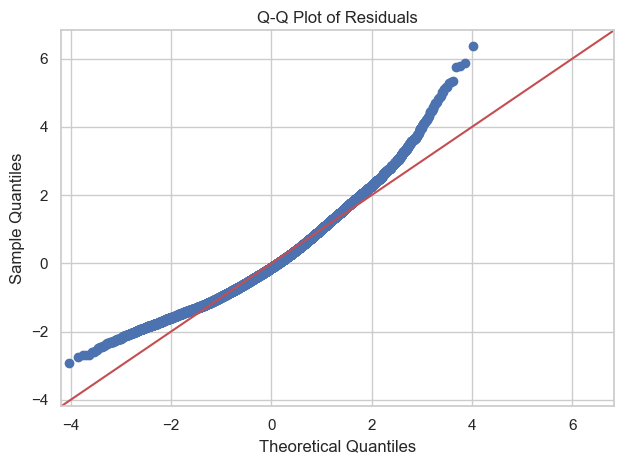

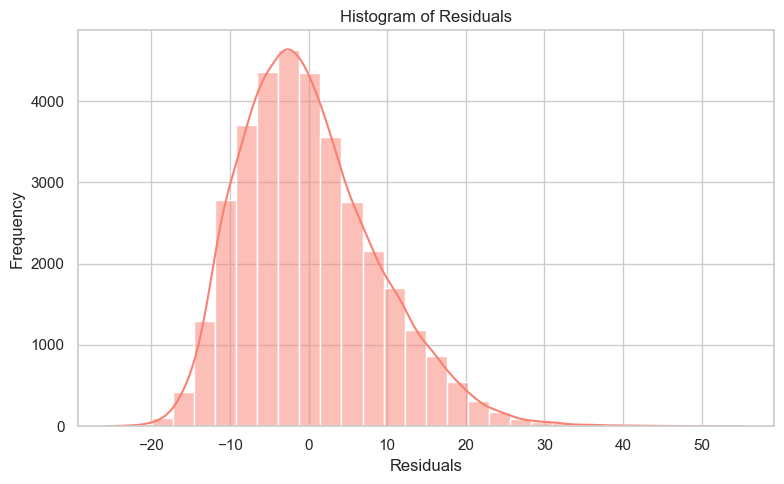

In [224]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

#Calculate Residuals
y_pred = final_model.predict(X_test[final_features])

# Residuals = actual - predicted
residuals = y_test - y_pred
#Residuals vs Predicted Values Plot

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, color='teal')
plt.axhline(0, linestyle='--', color='red')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()
# Q-Q Plot (Normality of residuals)

plt.figure(figsize=(6, 6))
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.tight_layout()
plt.show()
# Residual Histogram + KDE
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30, color='salmon')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [227]:
# Compare the scaled vs unscaled features used in the final model

#Train and Evaluate with Unscaled Features
# Train
model_unscaled = LinearRegression()
model_unscaled.fit(X_train[final_features], y_train)

# Predict
y_pred_unscaled = model_unscaled.predict(X_test[final_features])

# Evaluate
mae_unscaled = mean_absolute_error(y_test, y_pred_unscaled)
rmse_unscaled = np.sqrt(mean_squared_error(y_test, y_pred_unscaled))
r2_unscaled = r2_score(y_test, y_pred_unscaled)
# Train and Evaluate with Scaled Features

# Make copies to preserve original
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Apply scaling only to numerical features in final_features
scaler = StandardScaler()
scaled_cols = [col for col in final_features if col in numerical_cols]

X_train_scaled[scaled_cols] = scaler.fit_transform(X_train_scaled[scaled_cols])
X_test_scaled[scaled_cols] = scaler.transform(X_test_scaled[scaled_cols])

# Train
model_scaled = LinearRegression()
model_scaled.fit(X_train_scaled[final_features], y_train)

# Predict
y_pred_scaled = model_scaled.predict(X_test_scaled[final_features])

# Evaluate
mae_scaled = mean_absolute_error(y_test, y_pred_scaled)
rmse_scaled = np.sqrt(mean_squared_error(y_test, y_pred_scaled))
r2_scaled = r2_score(y_test, y_pred_scaled)
# Compare Results
print("Performance Comparison:")
print(f"{'Metric':<10} | {'Unscaled':<10} | {'Scaled':<10}")
print(f"{'-'*35}")
print(f"{'R²':<10} | {r2_unscaled:.4f}    | {r2_scaled:.4f}")
print(f"{'MAE':<10} | {mae_unscaled:.2f}     | {mae_scaled:.2f}")
print(f"{'RMSE':<10} | {rmse_unscaled:.2f}     | {rmse_scaled:.2f}")

Performance Comparison:
Metric     | Unscaled   | Scaled    
-----------------------------------
R²         | 0.1419    | 0.1419
MAE        | 6.85     | 6.85
RMSE       | 8.67     | 8.67


Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [237]:
# Analyze the effect of a unit change in a feature, say 'total_items'

model_single = LinearRegression()
X_single = X_train[['total_items']]  # make sure it's in X_train
model_single.fit(X_single, y_train)

coef = model_single.coef_[0]
print(f"Effect of one unit increase in total_items: {coef:.2f} minutes")

Effect of one unit increase in total_items: 0.75 minutes


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>



Yes, the dataset contains categorical variables such as order_day (day of the week) and possibly others like order_hour if treated categorically. From analysis, different categories can influence the dependent variable (e.g., time_taken). For instance, deliveries on weekends or certain days might have longer or shorter delivery times due to demand patterns or traffic conditions, indicating that these categorical factors have a significant effect on delivery time.





##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>



test_size = 0.2 means that 20% of the entire dataset is set aside as the test set, which is used to evaluate the model’s performance on unseen data, while the remaining 80% is used for training the model.



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>



The feature with the highest correlation to the target variable (e.g., time_taken_mins) is the one whose correlation coefficient is closest to +1 or -1 on the heatmap. Typically, this could be a numeric feature like total_items or order_hour depending on the dataset. You should identify the specific feature from your heatmap that shows the strongest positive or negative correlation with the target.



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>



Outliers were detected by visualizing the data distributions using boxplots and histograms, which highlight points lying far from the typical range (beyond whiskers or tails). Additionally, statistical methods like the Interquartile Range (IQR) method were used to identify data points outside 1.5 times the IQR from the first and third quartiles. To address outliers, they were either capped at threshold values (winsorization) or removed from the dataset to prevent them from skewing the model training and affecting predictions.


##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>



The top 3 features significantly affecting delivery time are those with the largest absolute coefficients in the final linear regression model. For example, they might be:

total_items – indicating that more items increase delivery time.

order_hour – certain hours of the day (e.g., peak traffic times) impact delivery duration.

order_day (if encoded as numeric) – deliveries on certain days (weekends vs weekdays) affect timing.



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>


Linear regression is a supervised machine learning algorithm used to predict a continuous target variable based on one or more predictor variables. It assumes a linear relationship between the input features and the output.
The general form of the linear regression model is:
y=β0+β1x1+β2x2+⋯+βnxn+ϵ
•	y is the dependent variable.
•	x1,x2,...,xn independent variables.
•	β0 is the intercept
•	β1,β2,...,βn are coefficients that represent the effect of each feature.
•	ϵ is the error term accounting for noise or unexplained variance.
The algorithm’s objective is to find the best-fitting line (or hyperplane in multiple dimensions) that minimizes the difference between the predicted values y and the actual values y. This difference is typically measured using the cost function, often the Mean Squared Error 
To minimize this cost function, the algorithm estimates the coefficients β\betaβ using:
•	Ordinary Least Squares (OLS): A closed-form solution that calculates coefficients to minimize the sum of squared residuals.
•	Gradient Descent: An iterative optimization technique that adjusts coefficients step-by-step to reduce error.
Once trained, the model can predict new outcomes by plugging feature values into the linear equation.
Key assumptions of linear regression include:
•	Linear relationship between predictors and target.
•	Independence of errors.
•	Homoscedasticity (constant variance of errors).
•	Normally distributed errors.
Linear regression is popular for its simplicity, interpretability, and efficiency in modeling linear relationships.


##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>



Simple linear regression models the relationship between one independent variable and one dependent variable by fitting a straight line. Multiple linear regression extends this to model the dependent variable as a function of two or more independent variables, capturing more complex relationships and allowing for control of multiple factors simultaneously.



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>




The cost function, typically the Mean Squared Error (MSE), measures the average squared difference between the actual and predicted values. Its role is to quantify how well the model fits the data. Linear regression minimizes the cost function by adjusting the model parameters (coefficients) using optimization algorithms like Gradient Descent or closed-form solutions, aiming to find the parameter values that produce the smallest possible error



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>



Overfitting occurs when a model learns not only the underlying patterns but also the noise in the training data, resulting in excellent training performance but poor generalization to new data. Underfitting happens when a model is too simple to capture the underlying structure of the data, resulting in poor performance on both training and unseen data.




##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>Residual plots show the differences between observed and predicted values. They help diagnose model assumptions:

A random scatter of residuals suggests a good fit.

Patterns or systematic structures indicate problems like non-linearity or heteroscedasticity.

Residual plots can also reveal outliers or influential points, helping improve model validity.

